## Scraping News data from Google News

In [1]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

import networkx as nx
from requests_html import HTMLSession # for google news source

import spacy
from spacy import displacy

In [ ]:
# load 'en_core_web_sm' from spacy
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words

# init HTMLSession instance
session = HTMLSession()

def fetch_article(url):
    '''  '''
    page = session.get(url)
    # ugly fix
    try:
        article = ' '.join(paragraph.text for paragraph in page.html.find('p'))
    except:
        return ''
    return article


def clean_text(text):
    '''  '''
    return ' '.join(token.lower() for token in text.split() if token.lower() not in stopwords)
    

def get_news(topic, n_top=10, session=session):
    '''  '''
    url = 'http://news.google.com/rss/search?q={}'.format(topic)
    page = session.get(url)

    news_dict = {
        'title':[title.text for title in page.html.find('title')[1:n_top]],
        'url':[link.html[7:] for link in page.html.find('link')[1:n_top]]
    }

    # search summary
    n_titles = len(news_dict['title'])
    n_urls = len(news_dict['url'])
    print(f'extracting news for topic: {topic}')
    print(f'n_title = {n_titles} ... n_urls = {n_urls}')

    news_df = pd.DataFrame(news_dict)
    news_df['body'] = news_df['url'].apply(lambda x: fetch_article(x))

    # clean article text
    news_df['title'] = news_df['title'].apply(lambda x: clean_text(x))
    news_df['body'] = news_df['body'].apply(lambda x: clean_text(x))

    news_df.drop('url', axis=1, inplace=True)

    news_df.to_csv('../data/world/raw/{}_news.csv'.format(topic), index=False)


# custom lists of topics to scrape
topics_list = [
    'US', 'China', 'UK', 'France', 'Germany', 'Russia', 'Japan', 'Italy', 'UAE', 'Israel', 'Canada', 
    'Spain', 'Brazil', 'Argentina', 'Peru', 'Mexico', 'Australia', 'India', 'Ukraine', 'Taiwan', 
    'EU', 'NATO', 'WHO', 'UN'  # countries
]

for topic in topics_list:
    get_news(topic, n_top=11)

In [2]:
# merge all news into single .csv file and export to 'data/processed/...'
world_news_files = [file for file in os.scandir('../data/world/raw') if '.csv' in file.name]

world_news_df = pd.DataFrame()

for file in world_news_files:
    df = pd.read_csv(file)
    world_news_df = pd.concat([world_news_df, df])

# dropping empty observations
world_news_df = world_news_df.dropna() 

# clean up indices and export to .csv
world_news_df.reset_index(inplace=True)
world_news_df.drop('index', axis=1, inplace=True)
world_news_df.to_csv('../data/world/world_news.csv', index=False) # export to 'data/processed/...'

# summary
world_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   235 non-null    object
 1   body    235 non-null    object
dtypes: object(2)
memory usage: 3.8+ KB


## Identifying Named Entities

In [3]:
# load 'en_core_web_sm' from spacy
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words

# import world_news.csv
world_news_df = pd.read_csv('../data/world/world_news.csv')

def clean_body(text):
    '''  '''
    text = text.replace("'s", '')
    text = text.replace("/", ' ')
    text = ''.join(char for char in text if char.isalnum() or char == ' ')
    return ' '.join(word for word in text.split(' ') if word not in stopwords)


def frequent_words(text):
    '''  '''
    unique_words = set(text.split(' '))
    freq_words = []
    for word in unique_words :
        if (word.isalpha()) and (word not in ['news', 'fox', 'cnn', 'bbc', 'data']):
            freq_words.append({'word':word, 'frequency':world_news_df['clean_body'][0].count(word)})

    freq_words_df = pd.DataFrame(freq_words).sort_values(by=['frequency'], ascending=False).reset_index()
    # ugly fix
    try:
        freq_words = ' '.join(freq_words_df['word'][i] for i in range(10))
    except:
        return ''

    return freq_words
    

def get_entities(doc):
    '''  '''
    doc = nlp(doc)
    return ' '.join(clean_body(ent.text) for ent in doc.ents if ent.label_ in ['PERSON', 'ORG', 'GPE'])

# generating new features
world_news_df['clean_title'] = world_news_df['title'].apply(lambda x: clean_body(x))
world_news_df['clean_body'] = world_news_df['body'].apply(lambda x: clean_body(x))
world_news_df['frequent_words'] = world_news_df['clean_body'].apply(lambda x: frequent_words(x))
world_news_df['entities'] = world_news_df['body'].apply(lambda x: get_entities(x))
# text summary feature
world_news_df['text_summary'] = world_news_df['clean_title'] + ' ' + world_news_df['entities'] + ' ' + world_news_df['frequent_words']

# dropping unnecessary columns
world_news_df.drop(columns=['title', 'body', 'clean_body'], axis=1, inplace=True)

world_news_df.head()

,clean_title,frequent_words,entities,text_summary
0,france makes condoms free younger 26 emergency...,new french free condom factset provided fund s...,refinitiv lipper emmanuel macron france emmanu...,france makes condoms free younger 26 emergency...
1,france offers free condoms young people free e...,new french free macron health condoms years ne...,emmanuel macron france amazon france macron cn...,france offers free condoms young people free e...
2,france offer free condoms adults age 25 onion,french free condoms macron emmanuel years pres...,emmanuel macron michelle bairwell joseph david...,france offer free condoms adults age 25 onion...
3,burkina faso military junta asks france recall...,de new un french provided year power state res...,france france france 24 acpm ojd france russia...,burkina faso military junta asks france recall...
4,iran judiciary indicts french nationals belgia...,french france years citizens mark state networ...,iran judiciary spokesperson belgium scriptseta...,iran judiciary indicts french nationals belgia...


## Building the Network

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# setting random seed
seed = 42069 # nice...

tfidf_vectors = TfidfVectorizer().fit_transform(list(world_news_df.text_summary)).toarray()
cosine_sim = cosine_similarity(tfidf_vectors)

G = nx.Graph()

for i in range(cosine_sim.shape[0]):
    G.add_node(i)
    for j in range(cosine_sim.shape[0]):
        if i == j or cosine_sim[i, j] <= 0.04:
            continue
        G.add_edge(i, j, weight=cosine_sim[i, j])


# ---*--- Network Summary ---*---
print('-----*----- Network Summary -----*-----')

# Number of nodes and edges
print('\n--- Nodes and Edges ---')
print(f'Total nodes: {G.number_of_nodes()}')
print(f'Total edges: {G.number_of_edges()}')
# Isolated Nodes
if len(list(nx.isolates(G))) == 0:
    print('There are no isolated nodes in your network!')
else:
    print(f'The following nodes are isolated: {list(nx.isolates(G))}')

# Diameter and Transitivity of your network
print('\n--- Diameter and Transitivity ---')
print(f'The Diameter of your network is: {nx.diameter(G)}')
print(f'The Transitivity of your network is: {round(nx.transitivity(G), 3)}')

# Node Degrees
print('\n--- Node Degrees ---')
degree_list = sorted((d for n, d in G.degree()), reverse=True)
print(f'The max degree value for a node is: {max(degree_list)}')
print(f'The average degree value for all nodes is: {round(sum(degree_list)/len(degree_list), 3)}')


-----*----- Network Summary -----*-----

--- Nodes and Edges ---
Total nodes: 235
Total edges: 5020
There are no isolated nodes in your network!

--- Diameter and Transitivity ---
The Diameter of your network is: 4
The Transitivity of your network is: 0.469

--- Node Degrees ---
The max degree value for a node is: 112
The average degree value for all nodes is: 42.723


## Visualizing the Network

Text(0.5, 0, 'Rank')

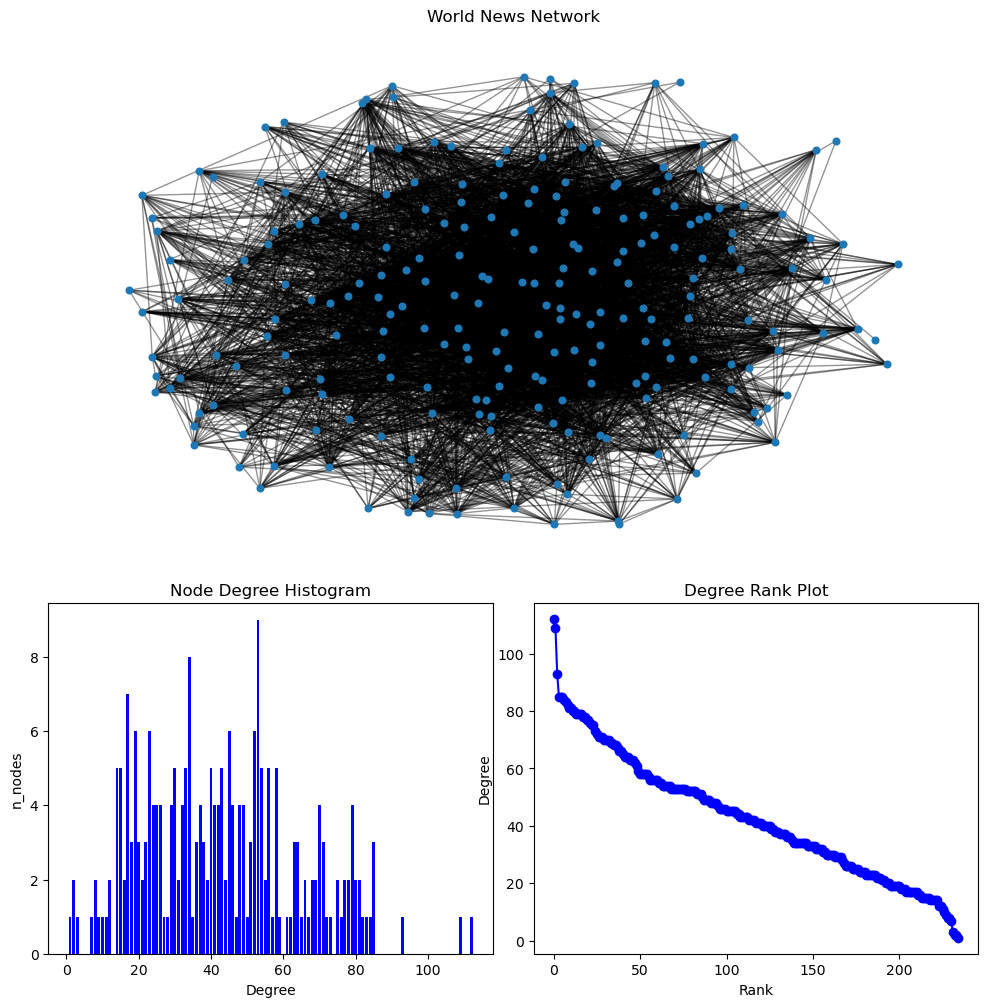

In [5]:
# init matplotlib.pyplot figure and gridspec
fig = plt.figure("World News Network", figsize=(12, 12))
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
layout = nx.spring_layout(G, seed=seed, k=10/np.sqrt(G.number_of_nodes()))
nx.draw_networkx_nodes(G, pos=layout, node_size=23)
nx.draw_networkx_edges(G, pos=layout, alpha=0.42)
ax0.set_title("World News Network")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.bar(*np.unique(degree_list, return_counts=True), color='b')
ax1.set_title("Node Degree Histogram")
ax1.set_xlabel("Degree")
ax1.set_ylabel("n_nodes")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.plot(degree_list, "b-", marker="o")
ax2.set_title("Degree Rank Plot")
ax2.set_ylabel("Degree")
ax2.set_xlabel("Rank")


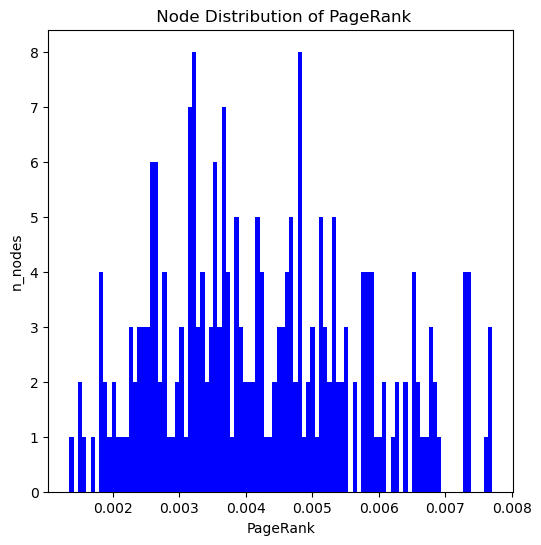

In [6]:
# plotting distribution of PageRank
pageRank = nx.pagerank(G, alpha=0.69)
pageRank = np.array(list(pageRank.values()))

fig = plt.figure("PageRank distribution", figsize=(6, 6))
ax = fig.add_subplot()
ax.hist(pageRank, bins=100, color='b')
ax.set_title(" Node Distribution of PageRank")
ax.set_xlabel("PageRank")
ax.set_ylabel("n_nodes")
plt.show()

In [7]:
from pyvis.network import Network
import community as community_louvain

# setting up node size attribute
node_degree = dict(G.degree)
nx.set_node_attributes(G, node_degree, 'size')

# setting up node group attribute
communities = community_louvain.best_partition(G)
nx.set_node_attributes(G, communities, 'group')

net = Network(notebook=True, cdn_resources='in_line', width='100%', height='100%', bgcolor='#222222', font_color='white')
net.force_atlas_2based() # set physics ... maybe barnes_hut()

net.from_nx(G)
net.show('../pyvis/world_news.html') # needs work!!!